# **Check GPU**

In [1]:
!nvidia-smi

Mon Sep  2 09:08:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Requirements**

In [2]:
!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.0/872.0 kB 20.1 MB/s eta 0:00:0000:01


# **Dataset - Weed**

In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="4LkXLK8ZSbLkfVFlFbMf")
project = rf.workspace("augmented-startups").project("weeds-nxe1w")
version = project.version(3)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.86, to fix: `pip install ultralytics==8.0.196`


# **LIBRARIES & DEPENDENCIES**

In [5]:
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [6]:
HOME = os.getcwd()
HOME

'/kaggle/working'

In [7]:
dataset_dir = f'{HOME}/Weeds-3/'
models_dir = f'{HOME}/models'
os.makedirs(models_dir, exist_ok=True)

# **Visualize Samples**

In [8]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [9]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [10]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

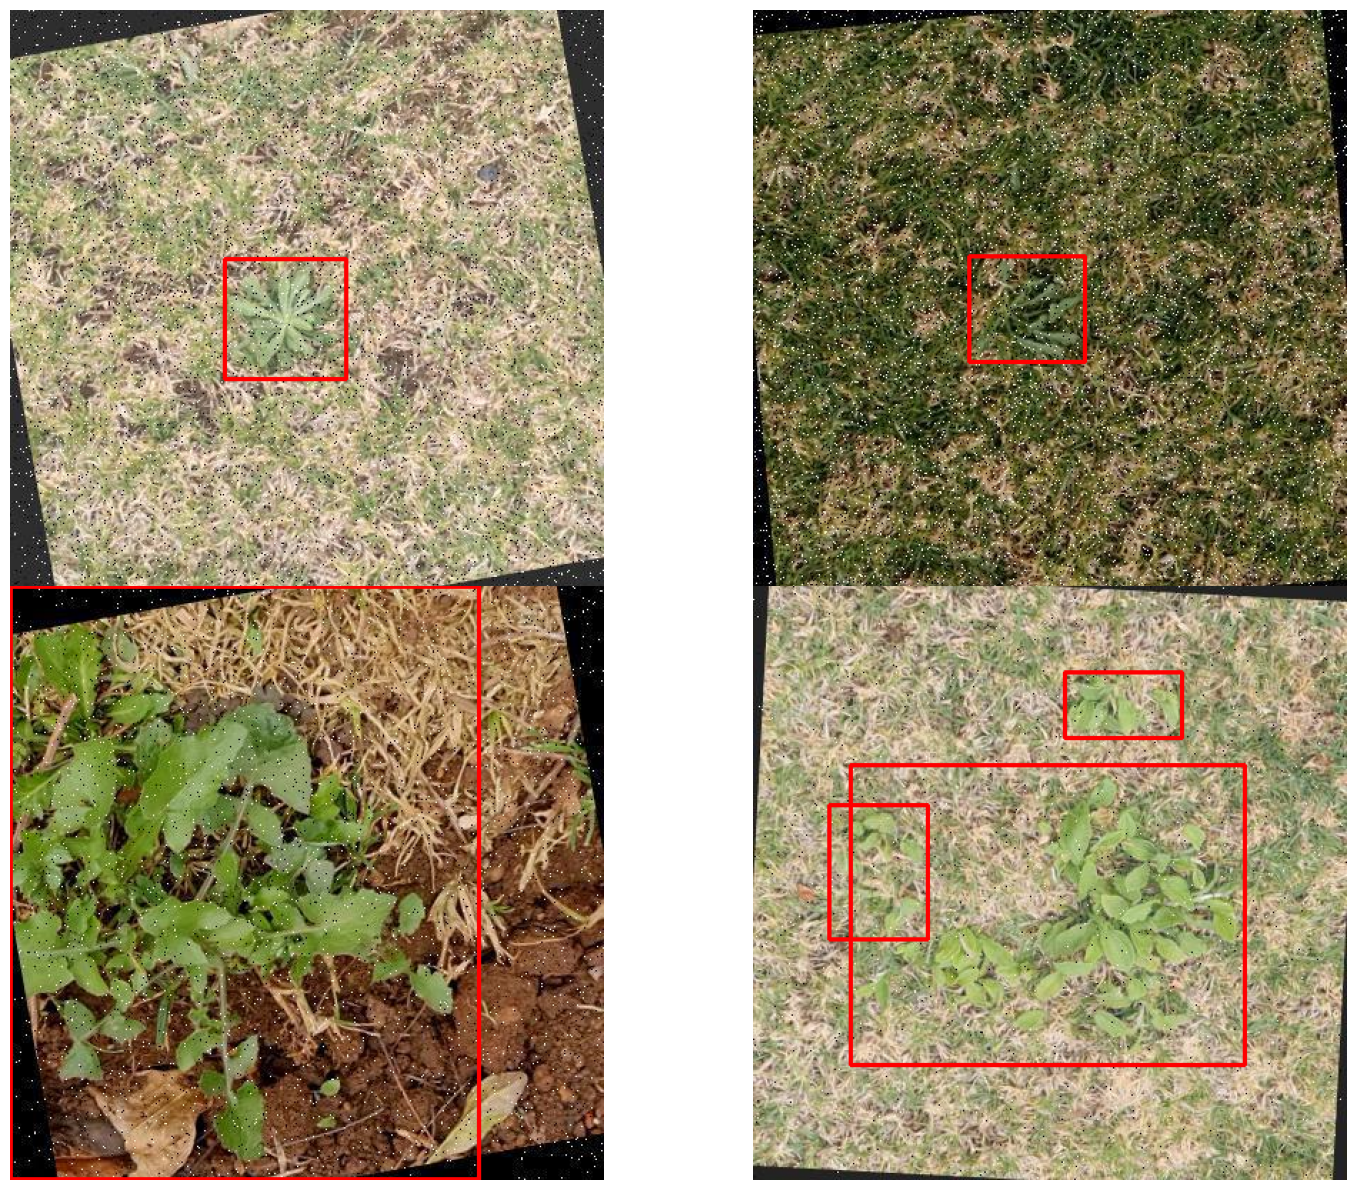

In [11]:
# Visualize a few training images.
plot(
    image_paths=f'{dataset_dir}/train/images/',
    label_paths=f'{dataset_dir}/train/labels/',
    num_samples=4,
)

# **YOLOv8**

In [12]:
import ultralytics
from ultralytics import YOLO

ultralytics.checks()

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5845.9/8062.4 GB disk)


In [13]:
modelS = YOLO(f"{models_dir}/yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 236MB/s]


WARNING ⚠️ 'source' is missing. Using 'source=/opt/conda/lib/python3.10/site-packages/ultralytics/assets'.



[ WARN:0@330.729] global loadsave.cpp:241 findDecoder imread_('/kaggle/working/test_image.jpg'): can't open/read file: check file path/integrity


image 1/2 /opt/conda/lib/python3.10/site-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 1421.9ms
image 2/2 /opt/conda/lib/python3.10/site-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 1 tie, 963.0ms
Speed: 10.8ms preprocess, 1192.5ms inference, 131.5ms postprocess per image at shape (1, 3, 384, 640)


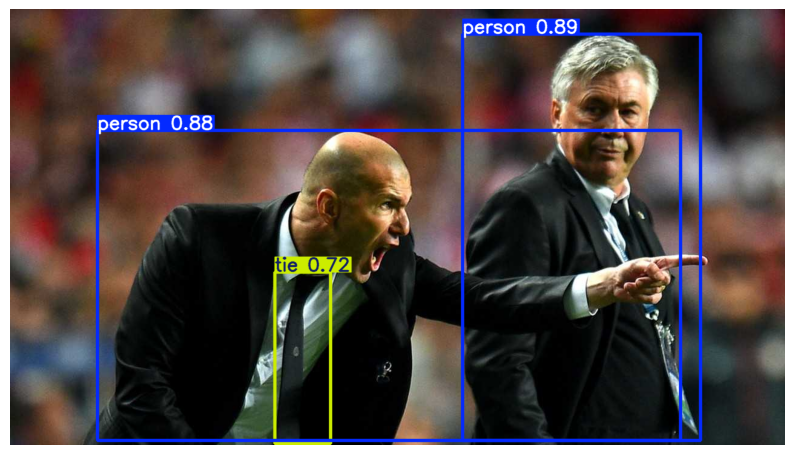

In [16]:
TEST_IMAGE_PATH = f'{HOME}/test_image.jpg'
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)
# TEST_IMAGE = cv2.resize(TEST_IMAGE, (640, 640))
CHECK_TEST_RESULT = modelS.predict(source=TEST_IMAGE, conf=0.5, save=False, imgsz=640)

plt.figure(figsize=(10, 10))
for result in CHECK_TEST_RESULT:
    plotted_image = result.plot()
    plotted_image_rgb = cv2.cvtColor(plotted_image, cv2.COLOR_BGR2RGB)
    plt.imshow(plotted_image_rgb)
    plt.axis('off')
plt.show()

# **Create YAML file**

In [17]:
yamlPath = f'{dataset_dir}/data.yaml'

In [18]:
yamlContent = f"""
path: '{dataset_dir}'
test: 'test/images'
train: 'train/images'
val: 'valid/images'

# class names
nc: 1
names:
  0: 'weed'
"""

with open(f'{yamlPath}', 'w') as yaml:
    yaml.write(yamlContent)

# **Define Parameters & Train Model**

In [19]:
EPOCHS = 20
IMAGE_SIZE = 420
BATCH = 32
NAME = 'yolov8s_weedv3'

In [21]:
# Train Model
modelS.train(
    data=yamlPath,            # Path to the dataset configuration file
    epochs=EPOCHS,            # Number of epochs to train for
    imgsz=IMAGE_SIZE,         # Image size
    batch=BATCH,              # Batch size
    name=NAME                 # Name of the training run
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/models/yolov8s.pt, data=/kaggle/working/Weeds-3//data.yaml, epochs=20, time=None, patience=100, batch=32, imgsz=420, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_weedv3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

100%|██████████| 755k/755k [00:00<00:00, 20.0MB/s]
2024-09-02 09:18:58,695	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-02 09:18:59,276	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 118MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[420] must be multiple of max stride 32, updating to [448]


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
train: Scanning /kaggle/working/Weeds-3/train/labels... 3664 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3664/3664 [00:02<00:00, 1235.54it/s]


train: New cache created: /kaggle/working/Weeds-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/Weeds-3/valid/labels... 359 images, 0 backgrounds, 0 corrupt: 100%|██████████| 359/359 [00:00<00:00, 1509.53it/s]

val: New cache created: /kaggle/working/Weeds-3/valid/labels.cache


Plotting labels to runs/detect/yolov8s_weedv3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 448 train, 448 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8s_weedv3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.944G       2.11      2.093      1.984         76        448: 100%|██████████| 115/115 [00:54<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.17s/it]

                   all        359        920      0.717      0.627      0.721      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.38G      1.471      1.214      1.451         54        448: 100%|██████████| 115/115 [00:34<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        359        920       0.84       0.74      0.846      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.37G      1.395      1.081      1.394         65        448: 100%|██████████| 115/115 [00:33<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  3.00it/s]

                   all        359        920      0.837      0.767      0.853      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.37G      1.355      1.018       1.37         71        448: 100%|██████████| 115/115 [00:33<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        359        920       0.86      0.802      0.891       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       5.4G        1.3     0.9303      1.319         95        448: 100%|██████████| 115/115 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        359        920      0.861      0.798      0.888      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.37G      1.264     0.8889      1.302         74        448: 100%|██████████| 115/115 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        359        920      0.867      0.854      0.922      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       5.4G      1.225      0.844      1.268         58        448: 100%|██████████| 115/115 [00:33<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

                   all        359        920      0.896      0.818      0.908      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.37G      1.189     0.8009      1.244         92        448: 100%|██████████| 115/115 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        359        920      0.914      0.837       0.93      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       5.4G      1.151     0.7726      1.226         67        448: 100%|██████████| 115/115 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

                   all        359        920      0.918      0.866      0.944      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.37G      1.109     0.7259        1.2        103        448: 100%|██████████| 115/115 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        359        920      0.917      0.889      0.948      0.669


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       5.4G      1.024     0.5879      1.136         22        448: 100%|██████████| 115/115 [00:35<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        359        920       0.93      0.901      0.961       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.37G     0.9984     0.5578      1.123         57        448: 100%|██████████| 115/115 [00:32<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        359        920       0.91      0.922      0.955      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       5.4G     0.9805     0.5368      1.104         26        448: 100%|██████████| 115/115 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

                   all        359        920       0.92      0.902      0.956      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.37G     0.9567     0.5152      1.094         54        448: 100%|██████████| 115/115 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]

                   all        359        920      0.925      0.907      0.961      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.38G     0.9311     0.4958      1.073         43        448: 100%|██████████| 115/115 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

                   all        359        920       0.94      0.904      0.968      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.38G     0.9068     0.4738      1.055         46        448: 100%|██████████| 115/115 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        359        920      0.908      0.952      0.973      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       5.4G     0.8822     0.4558      1.047         51        448: 100%|██████████| 115/115 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        359        920      0.927      0.938      0.968      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.37G     0.8711     0.4427      1.037         32        448: 100%|██████████| 115/115 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        359        920      0.924      0.934       0.97      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       5.4G     0.8543     0.4329       1.03         35        448: 100%|██████████| 115/115 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

                   all        359        920      0.926      0.937      0.971      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.38G     0.8319     0.4151      1.017         38        448: 100%|██████████| 115/115 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        359        920      0.923      0.935      0.971      0.769



20 epochs completed in 0.213 hours.
Optimizer stripped from runs/detect/yolov8s_weedv3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_weedv3/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_weedv3/weights/best.pt...
Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


                   all        359        920      0.923      0.934      0.971      0.769
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/yolov8s_weedv3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x787324b56fe0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [23]:
import shutil
shutil.make_archive('runs', 'zip', 'runs')

from IPython.display import FileLink
FileLink(r'runs.zip')

/kaggle/working/runs.zip

# **PLOTS**

In [24]:
from IPython.display import display, Image
from IPython import display
display.clear_output()

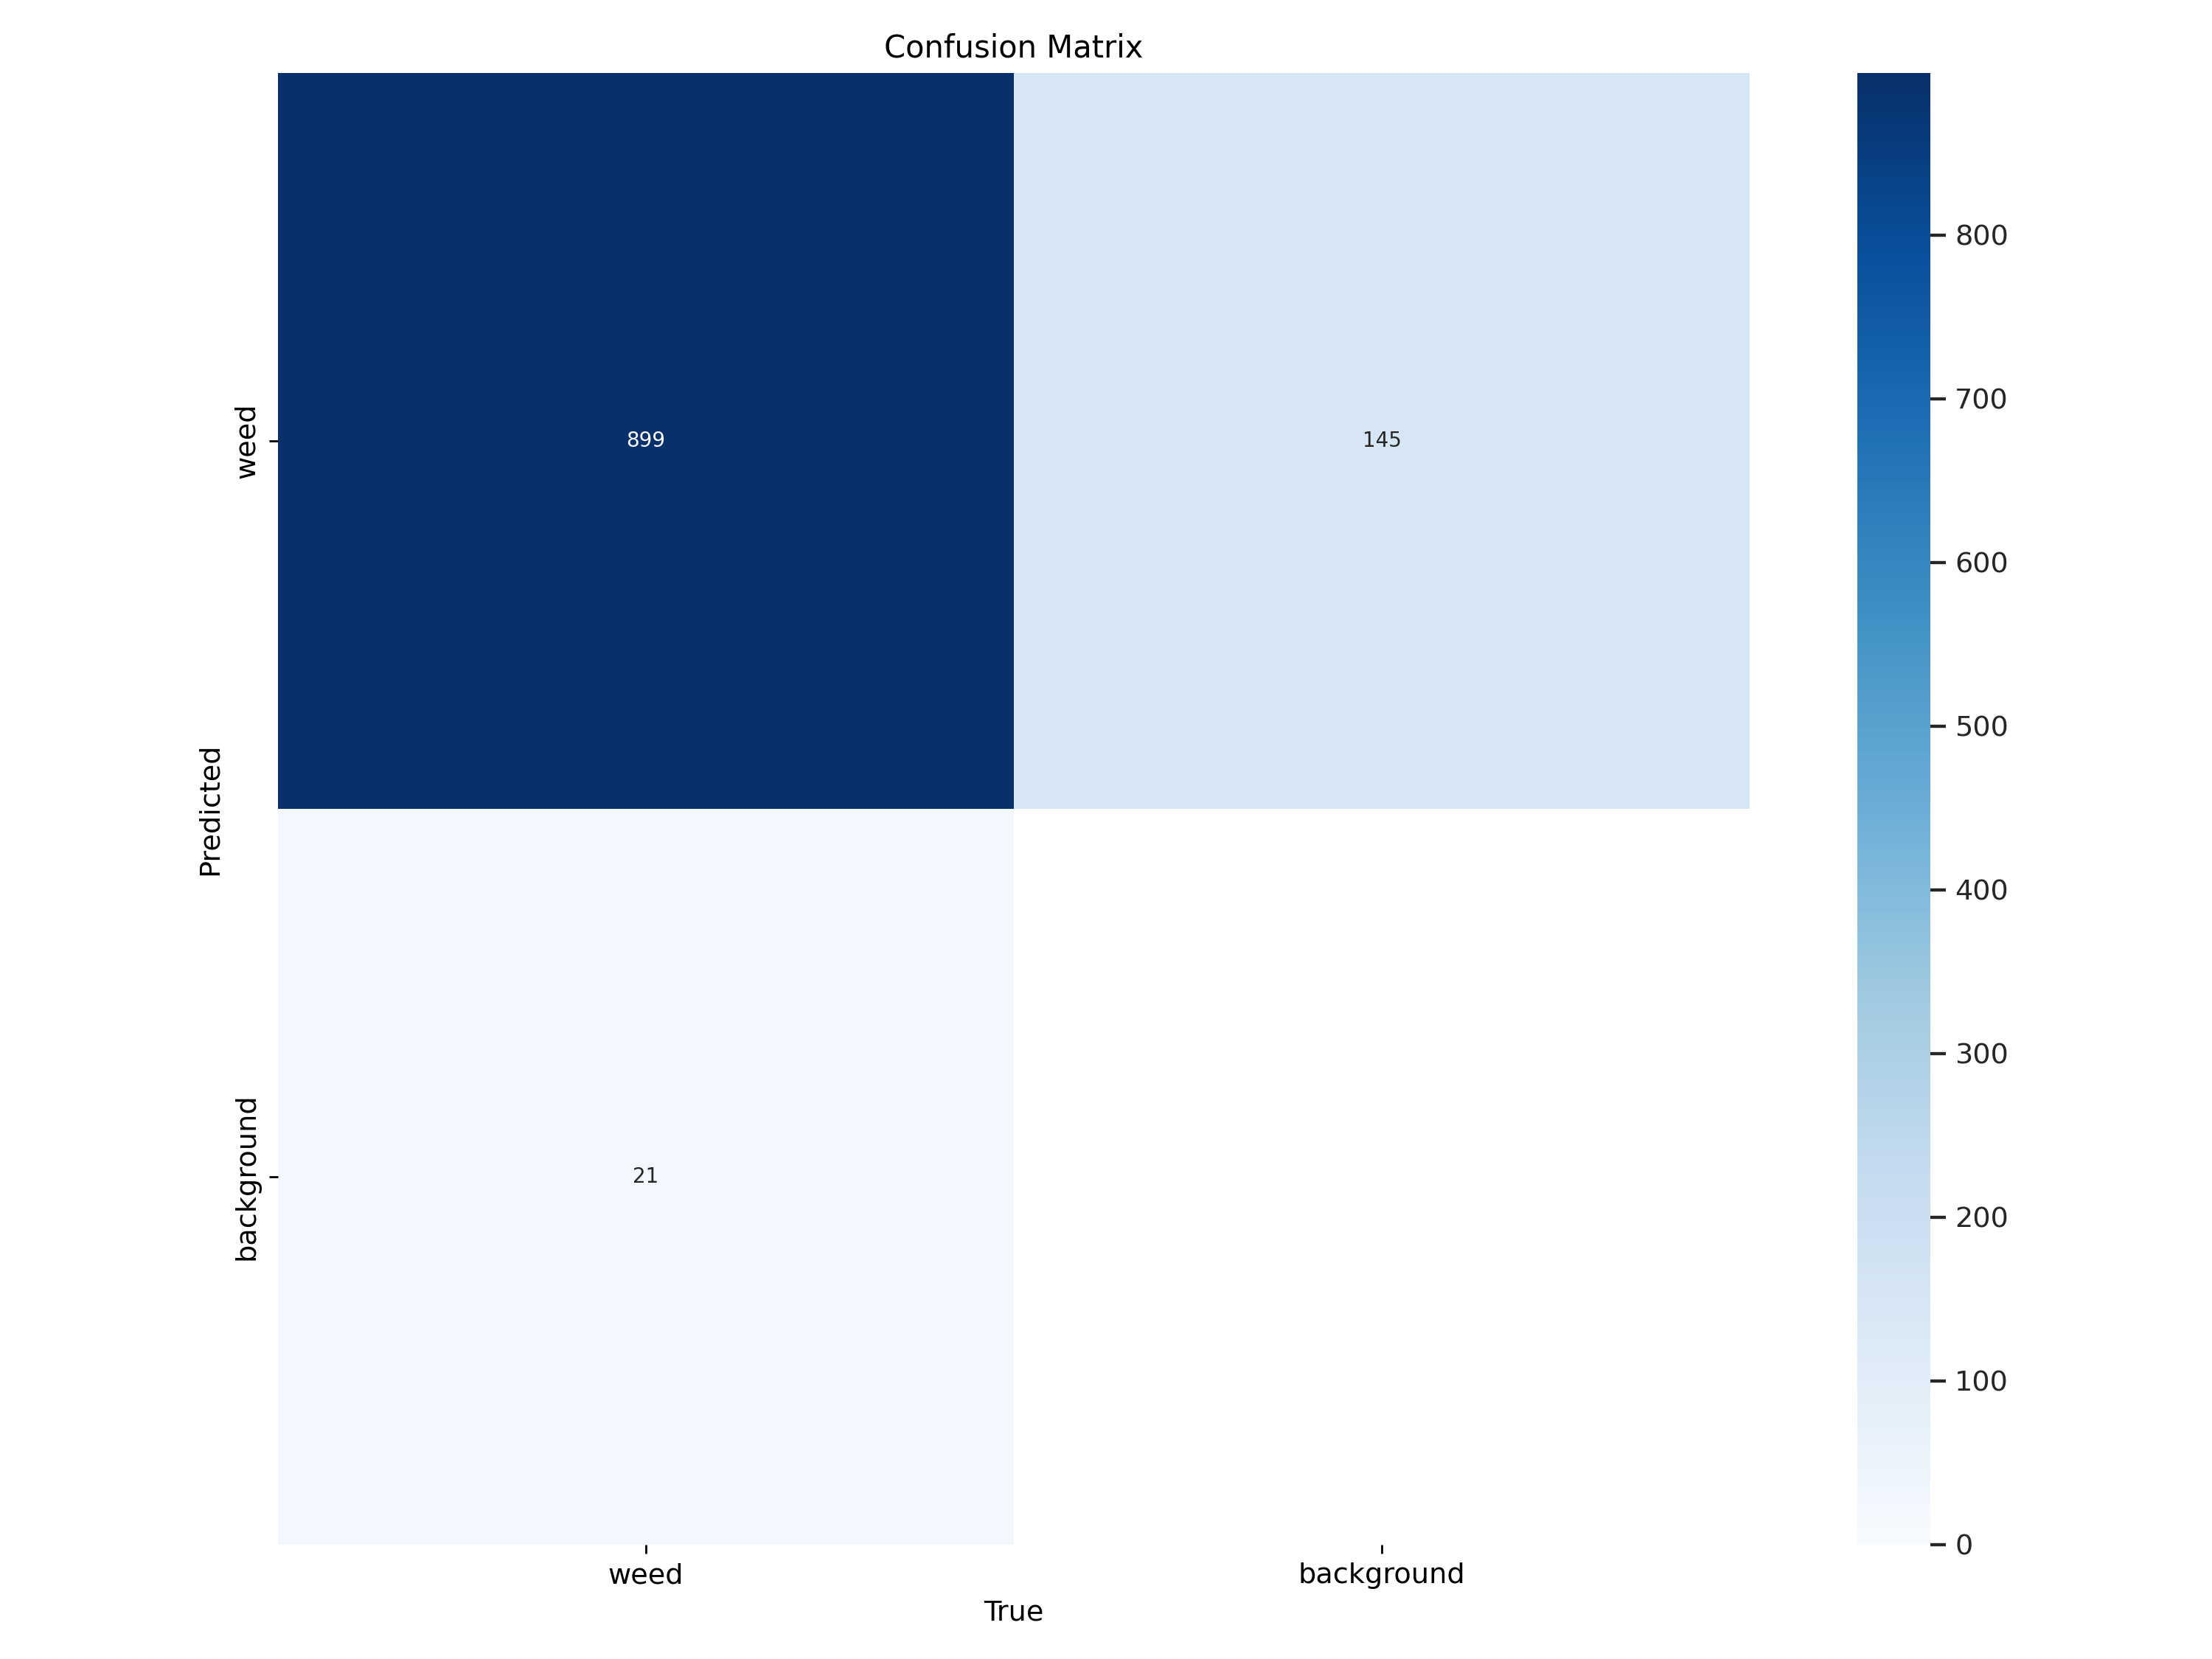

In [25]:
Image(filename=f'{HOME}/runs/detect/{NAME}/confusion_matrix.png', width=600)

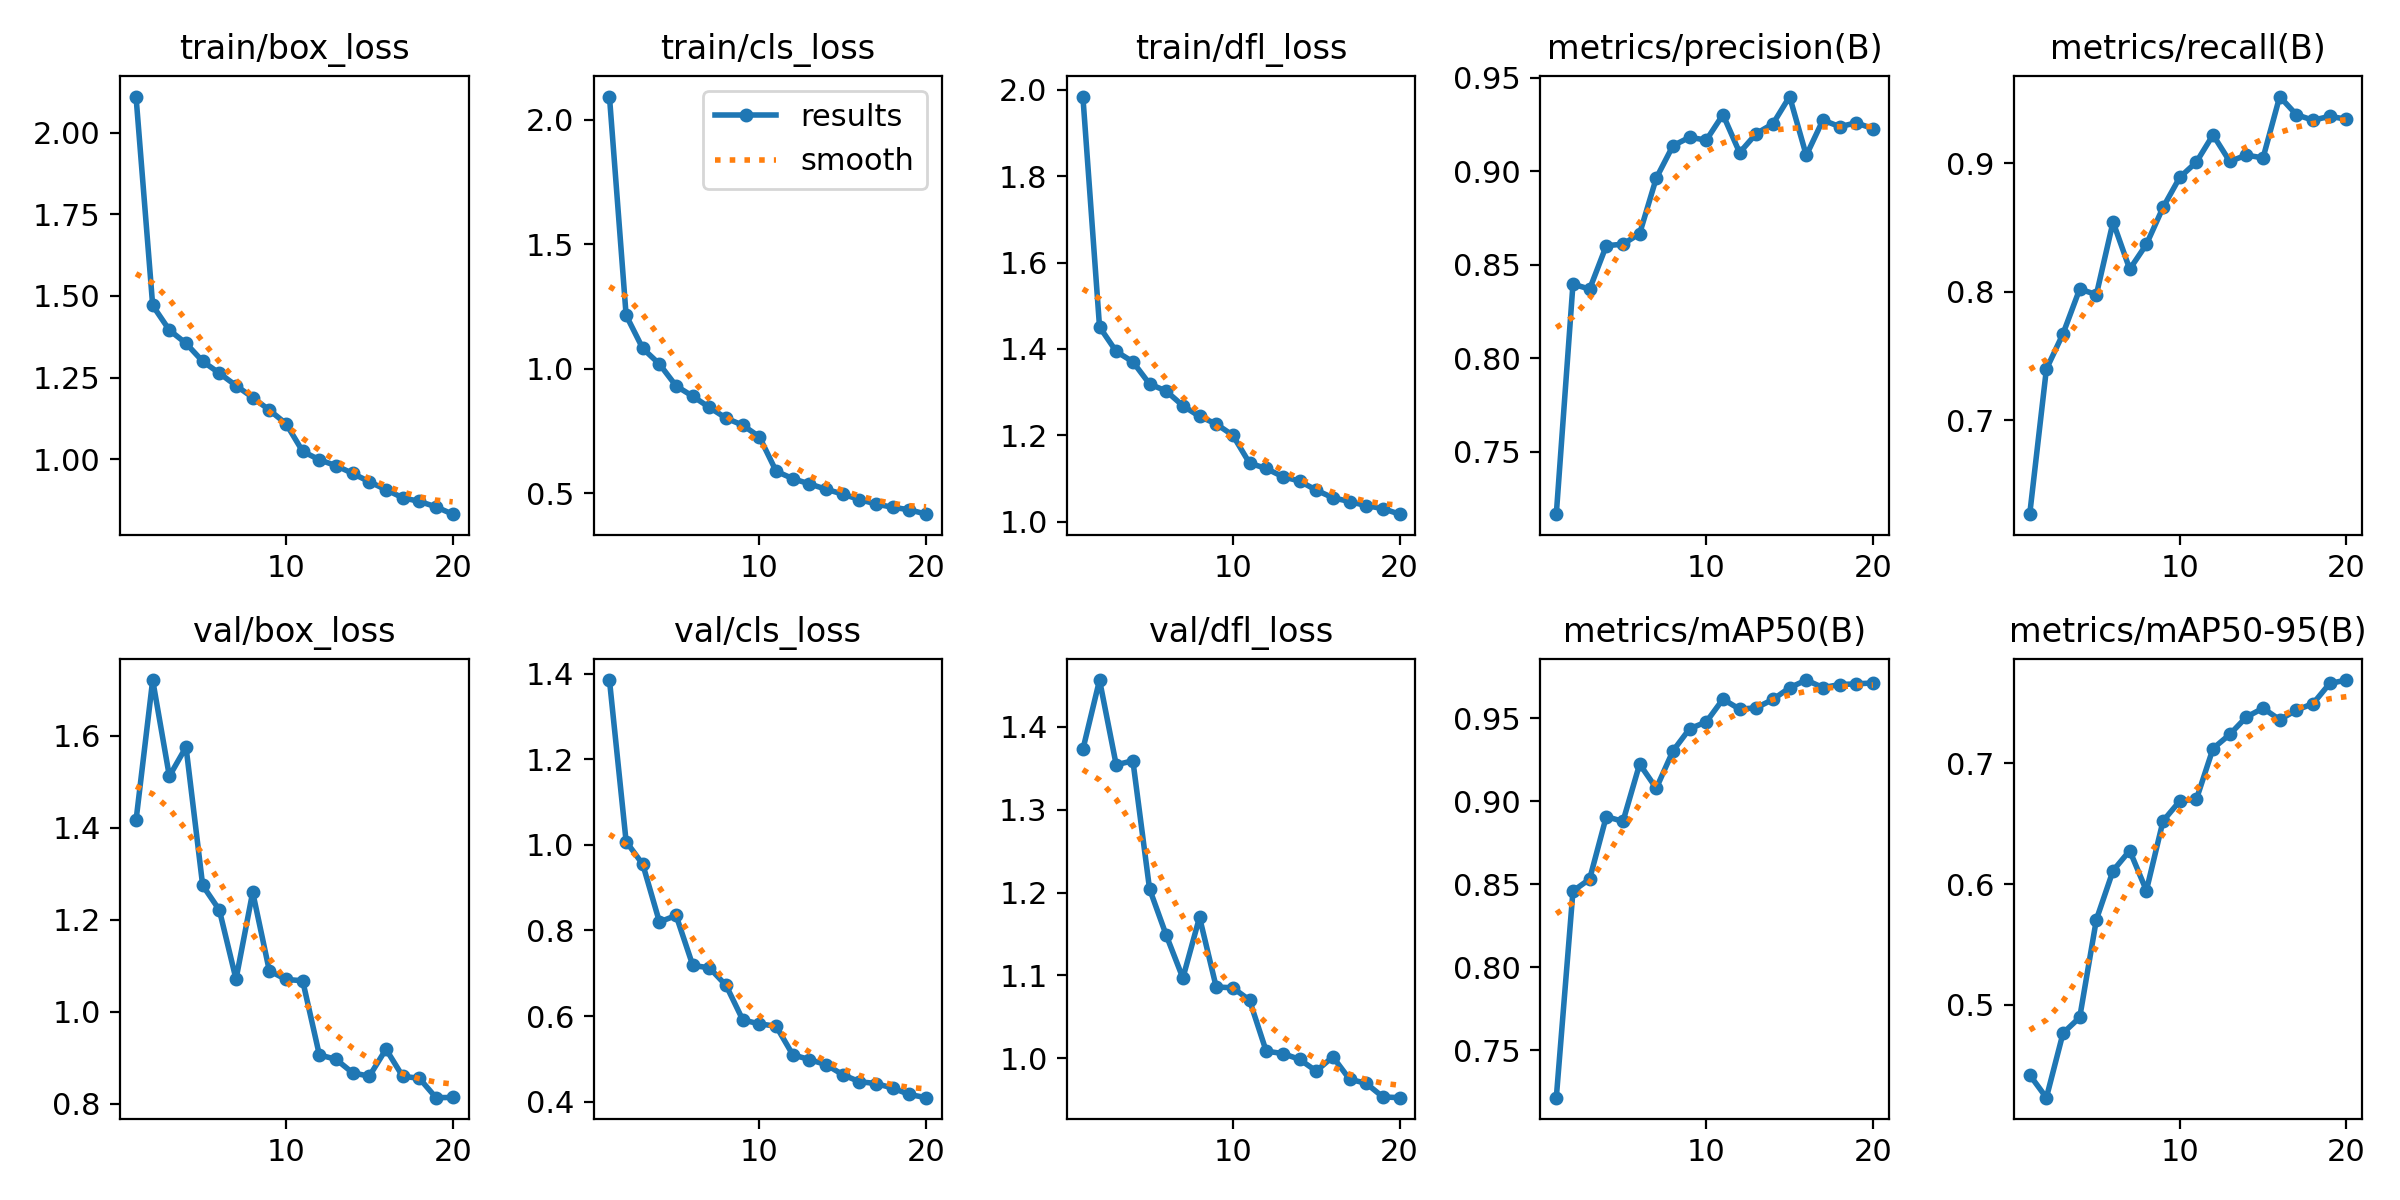

In [26]:
Image(filename=f'{HOME}/runs/detect/{NAME}/results.png', width=600)

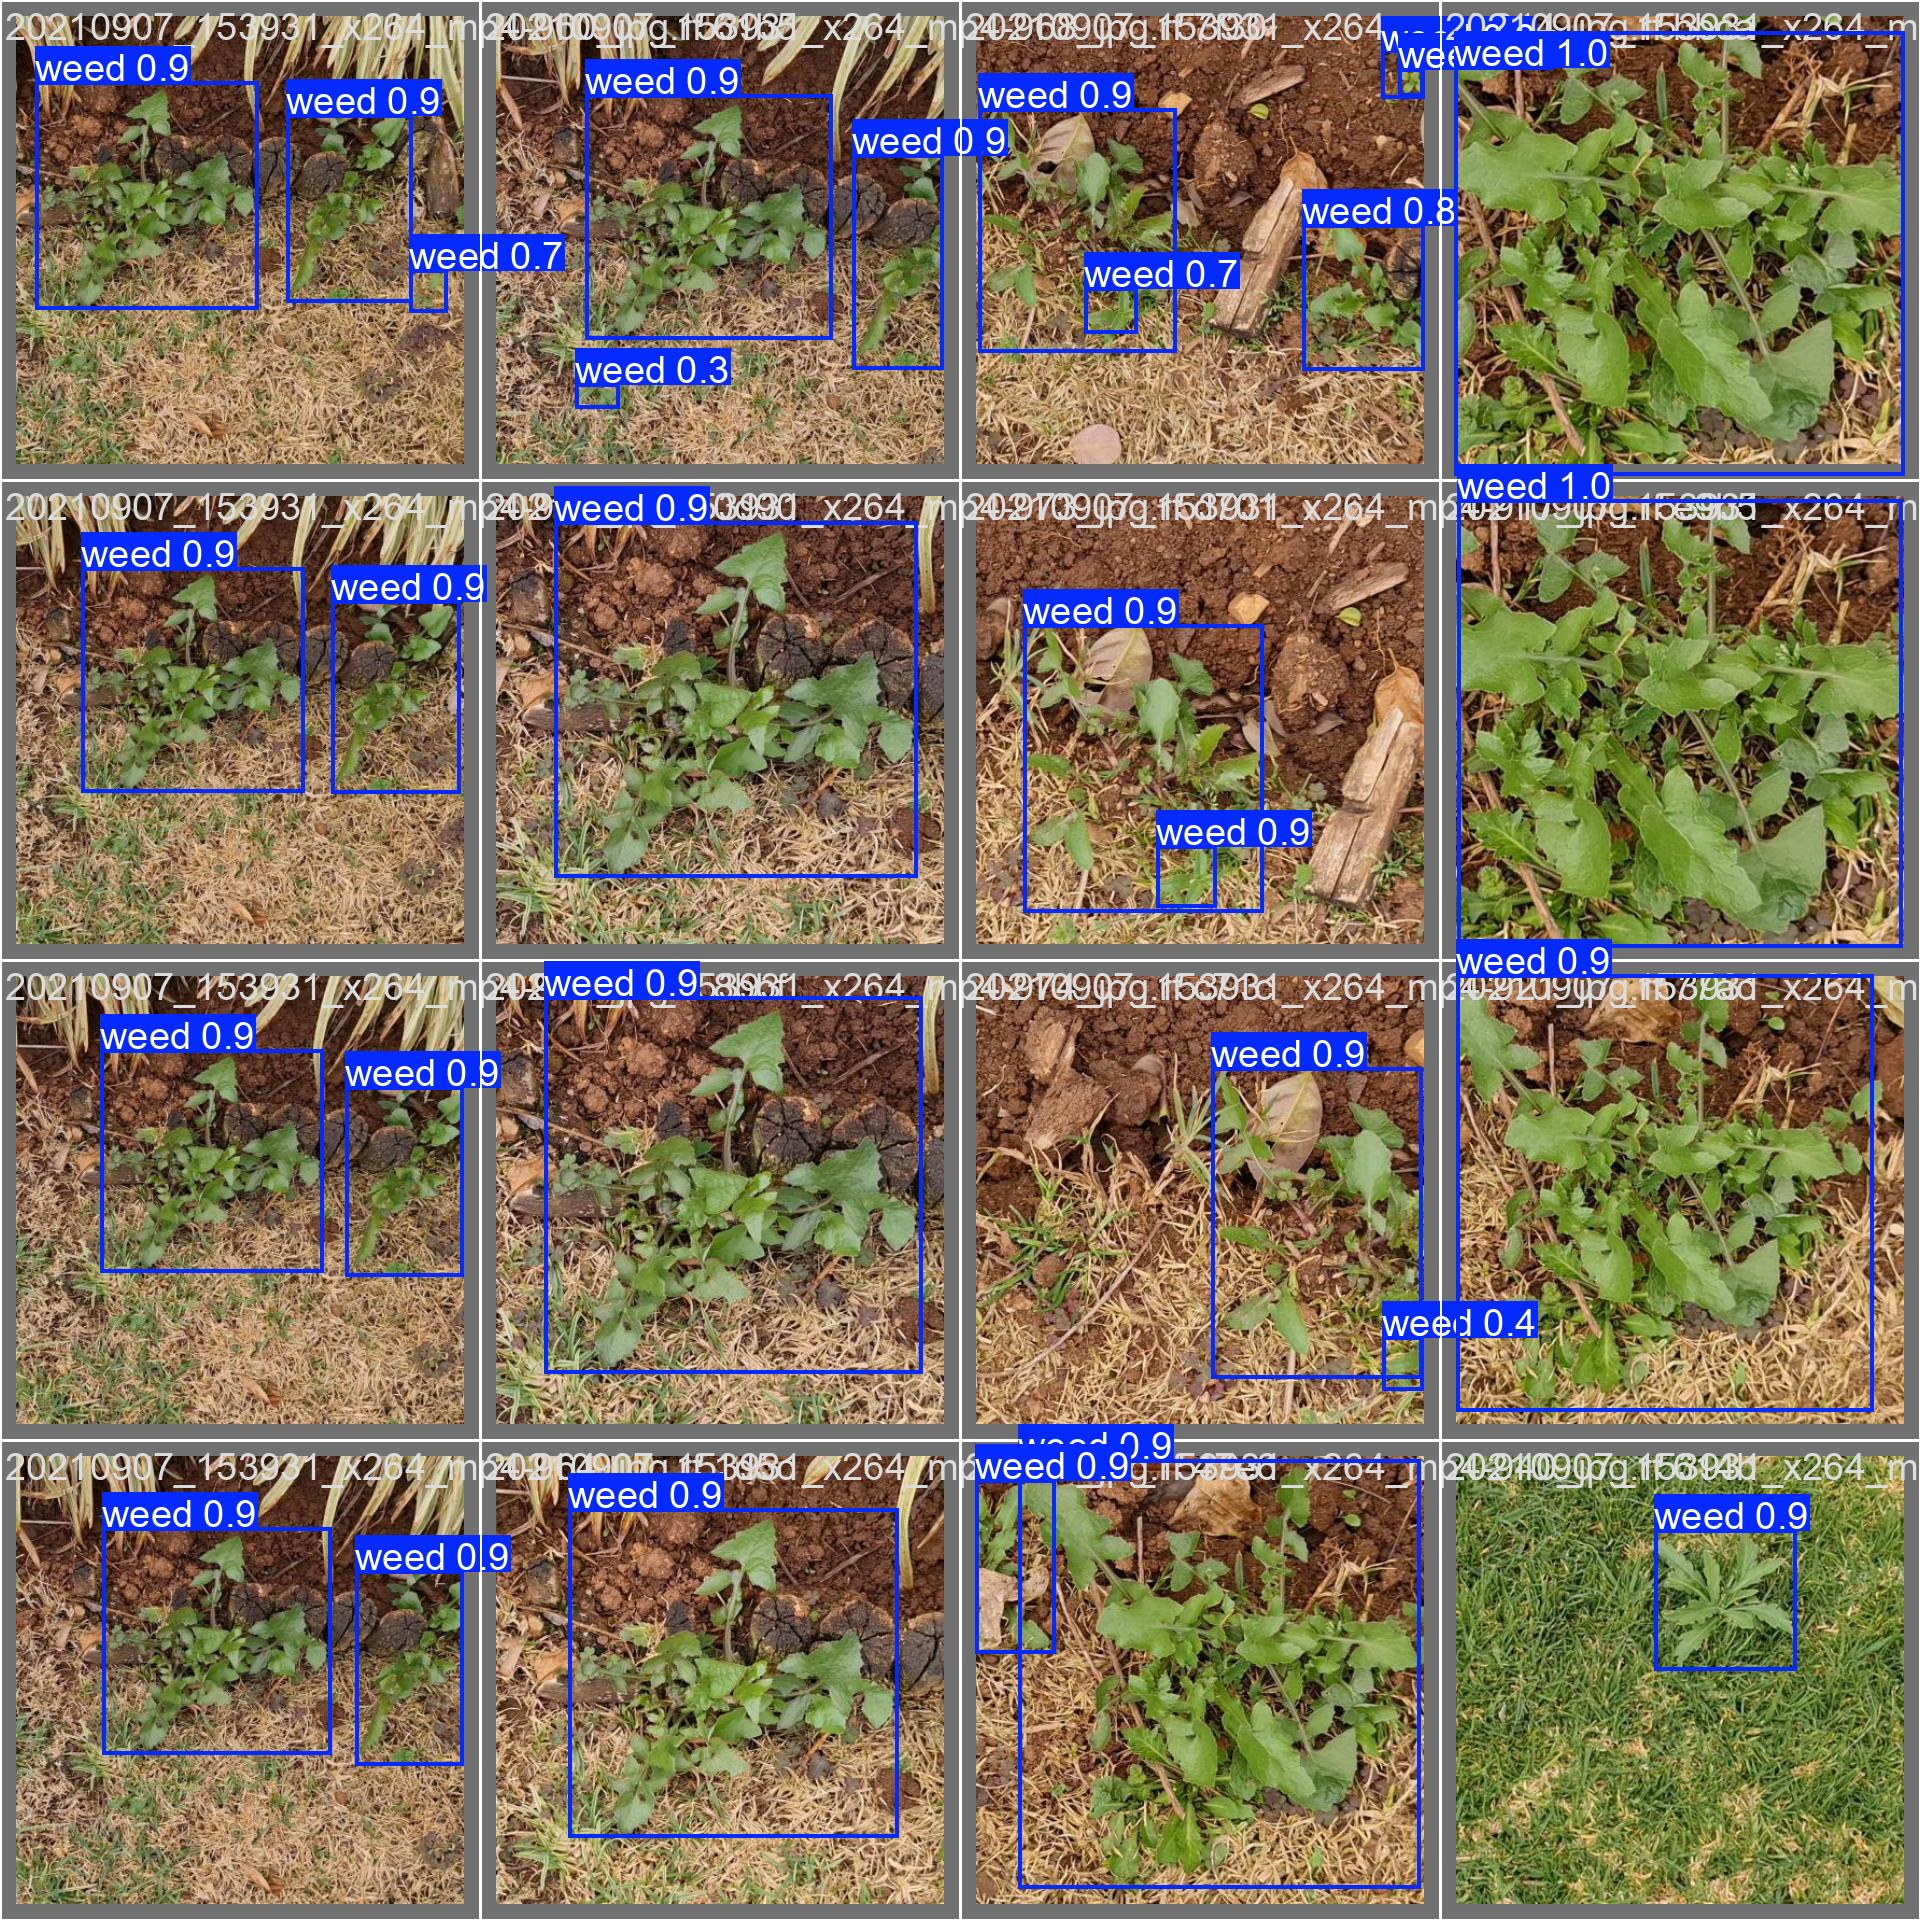

In [27]:
Image(filename=f'{HOME}/runs/detect/{NAME}/val_batch0_pred.jpg', width=600)